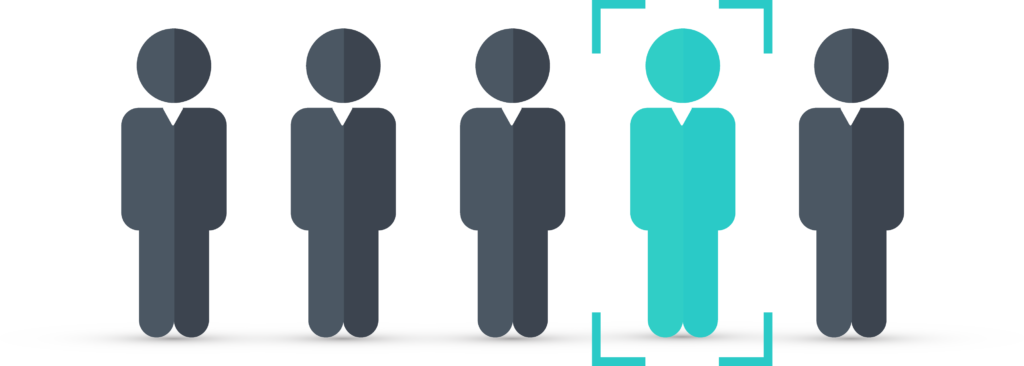

<h2 style="font-family:verdana;"> Case Study: Employee Churn Analysis </h2>
<p><i>Using data analytics to deep-dive into the understanding the why.</i></p>
<br>
<p>Author: Nathan Berrett.</p>

***

<b>“Train people well enough so they can leave. Treat them well enough so they don’t want to.”</b> - Sir Richard Branson

In this notebook, we will explore a case study of an unknown company wanting to build a prediction model to identify if an employee is likely to leave. 
Potential ethical reasons aside, we will build the model but also deep dive into the data to identify and common trends or strong outliers that might determine a root issue.

1. <b>Context</b>. We'll get some understanding of the data and its source.
2. <b>High Level Overview</b>. We'll have a quick look at the data to get some understanding.
3. <b>Clustering</b>. We'll look at building some clustering to determine a focus group of employees.
4. <b>Deep dive</b>. We'll dive deeper into our target group to try and determine whats happening.
5. <b>Prediction Model</b>. We'll build out a prediction model on the dataset.
6. <b>Validation</b>. We'll validate and test our findings

Now, it's time to have fun!

# 1. Context 
<p>This database is from a large US company (no name given for privacy reasons). The management department is worried about the relatively high turnover. They want to find ways to reduce the number of employees leaving the company and to better understand the situation, which employees are more likely to leave, and why.</p>

<p><b>The data</b></p>
<br>
<p>
        The HR department has assembled data on almost 10,000 employees who left the company between 2016-2020. They used information from exit interviews, performance reviews, and employee records.<br>
        <ol>
            <li><b>"department"</b> - the department the employee belongs to.</li>
            <li><b>"promoted"</b> - 1 if the employee was promoted in the previous 24 months, 0 otherwise.</li>
            <li><b>"review"</b> - the composite score the employee received in their last evaluation.</li>
            <li><b>"projects"</b> - how many projects the employee is involved in.</li>
            <li><b>"salary"</b> - for confidentiality reasons, salary comes in three tiers: low, medium, high.</li>
            <li><b>"tenure"</b> - how many years the employee has been at the company.</li>
            <li><b>"satisfaction"</b> - a measure of employee satisfaction from surveys.</li>
            <li><b>"bonus"</b> - 1 if the employee received a bonus in the previous 24 months, 0 otherwise.</li>
            <li><b>"avghrsmonth"</b> - the average hours the employee worked in a month.</li>
            <li><b>"left"</b> - "yes" if the employee ended up leaving, "no" otherwise.</li>
        </ol>
    </p>
<p>

# 1.1 Importing Libraries and Loading Data

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # for plotting graphs
import seaborn as sns # for plotting graphs
import plotly.express as px # for plotting graphs
from plotly.offline import init_notebook_mode, iplot
import warnings

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Pandas Settings
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore")

# settings for plotly
init_notebook_mode(connected=True)

/kaggle/input/employee-turnover/employee_churn_data.csv


In [2]:
df = pd.read_csv('../input/employee-turnover/employee_churn_data.csv')

In [3]:
df.head()

,department,promoted,review,projects,salary,tenure,satisfaction,bonus,avg_hrs_month,left
0,operations,0,0.577569,3,low,5.0,0.626759,0,180.866070,no
1,operations,0,0.751900,3,medium,6.0,0.443679,0,182.708149,no
2,support,0,0.722548,3,medium,6.0,0.446823,0,184.416084,no
3,logistics,0,0.675158,4,high,8.0,0.440139,0,188.707545,no
4,sales,0,0.676203,3,high,5.0,0.577607,1,179.821083,no


In [4]:
len(df)

9540

In [5]:
df.info

<bound method DataFrame.info of       department  promoted    review  projects  salary  tenure  satisfaction  bonus  avg_hrs_month left
0     operations         0  0.577569         3     low     5.0      0.626759      0     180.866070   no
1     operations         0  0.751900         3  medium     6.0      0.443679      0     182.708149   no
2        support         0  0.722548         3  medium     6.0      0.446823      0     184.416084   no
3      logistics         0  0.675158         4    high     8.0      0.440139      0     188.707545   no
4          sales         0  0.676203         3    high     5.0      0.577607      1     179.821083   no
...          ...       ...       ...       ...     ...     ...           ...    ...            ...  ...
9535  operations         0  0.610988         4  medium     8.0      0.543641      0     188.155738  yes
9536   logistics         0  0.746887         3  medium     8.0      0.549048      0     188.176164  yes
9537  operations         0  0.55

# 2. High Level Overview

In order to understand our data, we can look at different variables to try to understand their meaning and relevance to this problem.

Im particualary interested in understanding the relationships between whether an employee has left, and the following variables: 
* <b>tenure</b> 
* <b>satisfaction</b>
* <b>review</b> 
* <b>promoted</b>
* <b>bonus</b> 

In [6]:
left = df.groupby('left')
left.mean()

,promoted,review,projects,tenure,satisfaction,bonus,avg_hrs_month
left,,,,,,,
no,0.034340,0.635164,3.279455,6.546625,0.505634,0.215068,184.637605
yes,0.020474,0.692262,3.263649,6.579382,0.502244,0.204741,184.719730


Doesnt appear to be any immediate standout correlation between whether an employee has left and influencing factors....but we can run a sns plot anyway

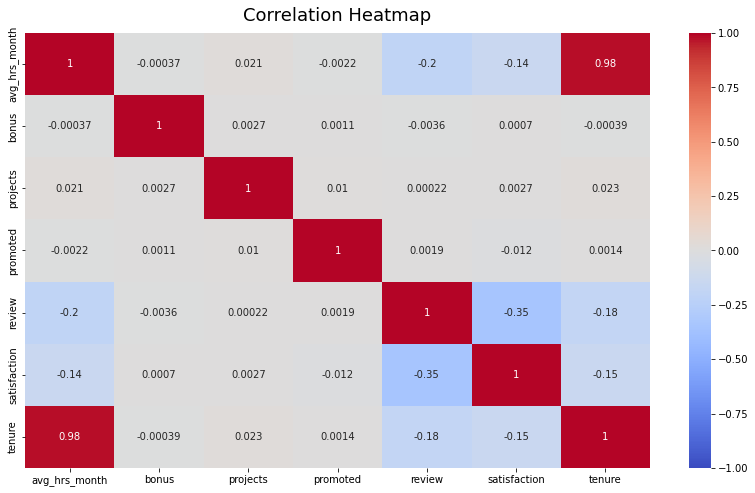

In [7]:
# Normalise the numbers as some of these are wild
df_norm_col=(df-df.mean())/df.std()
plt.figure(figsize=(14, 8))
heatmap = sns.heatmap(df_norm_col.corr(), vmin=-1, vmax=1, annot=True, cmap='coolwarm')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=12);

 Interesting there is a strong correlation between tenure and average hours worked per month, could resigning from overwork be a case? Let's look at this in a bit before going down a rabbit hole..

## 2.1 Breaking down the datapoints 

<p> Nothing immediate to report, but if we start looking at it across individual variables we might be able to identify something </p>

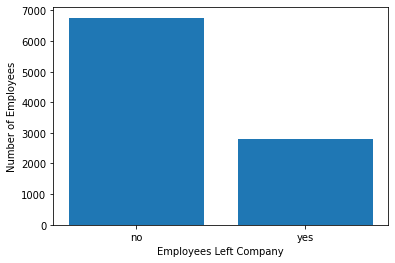

In [8]:
left_count=df.groupby('left').count()
plt.bar(left_count.index.values, left_count['satisfaction'])
plt.xlabel('Employees Left Company')
plt.ylabel('Number of Employees')
plt.show()

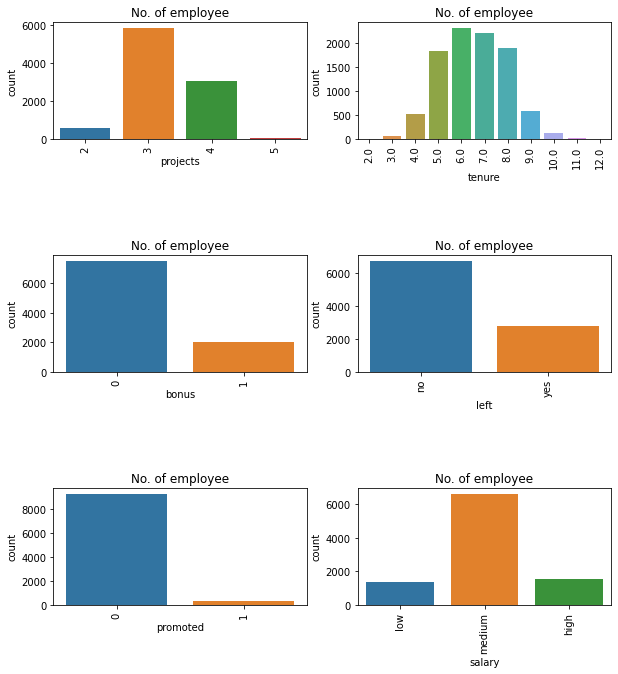

In [9]:
features=['projects','tenure','bonus','left', 'promoted','salary']
fig=plt.subplots(figsize=(10,15))
for i, j in enumerate(features):
    plt.subplot(4, 2, i+1)
    plt.subplots_adjust(hspace = 1.0)
    sns.countplot(x=j,data = df)
    plt.xticks(rotation=90)
    plt.title("No. of employee")

<p>Lets break it up by whether an employee has left or not.... </p>

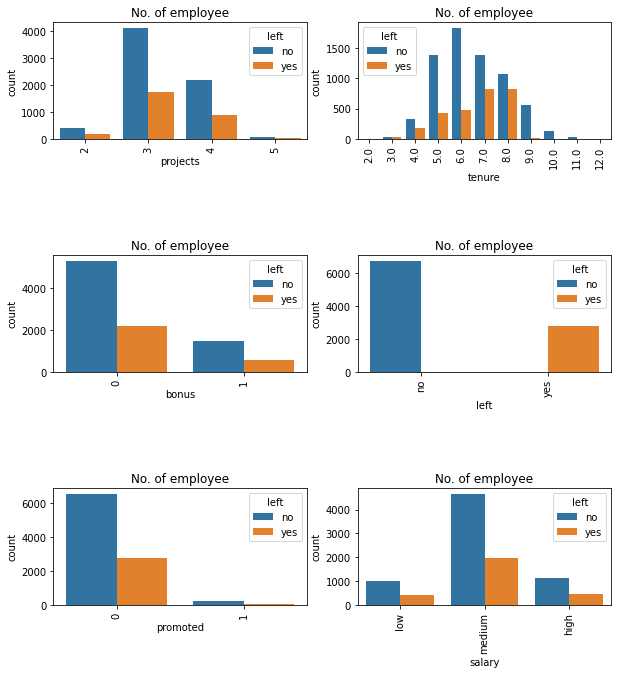

In [10]:
fig=plt.subplots(figsize=(10,15))
for i, j in enumerate(features):
    plt.subplot(4, 2, i+1)
    plt.subplots_adjust(hspace = 1.0)
    sns.countplot(x=j,data = df, hue='left')
    plt.xticks(rotation=90)
    plt.title("No. of employee")

<p>Nothing to shout out about, except the tenure. Its interesting that around year 8 tenureship, the number of employees leaving vs. staying are around the same. </p>

<p>We've identified a couple of trends that are work looking into: </p>

*      Tenure vs. number of hours worked
*      Tenure and number of employees that have left 

# 2.2 Going deeper 

Lets look at the relationship between tenure, the number of hours worked and if the employees have left or not.

In [11]:
fig = px.scatter(df, x="tenure", y="avg_hrs_month", facet_col="left", width=800, height=400, trendline='ols', trendline_color_override ='#fcba03', color_discrete_sequence=px.colors.qualitative.G10)
fig.update_layout(title='Tenure vs. Avg Hours Per Month Worked',
                   xaxis_title='Tenure (in years)',
                   yaxis_title='Avg Num of Hours worked p/month')
fig.show()

<p> In general, cant really make much from this. It appears overall, irregardless of left or not, that the longer you work at this company - the more hours you end up working. </p>

<p> With more data, and maybe sentiment analysis you could look for signs of overwork. You could also draw an assumption that inefficiencies exist with the longer tenured workers..... </p>

# 3. Clustering 

<p> We'll start performing some clustering analysis to see if we can identify a target cohort to deep dive into and draw comparisons </p>

<p> I'm particualary interested in 2 key clustering themes: </p> 

* <b>Performance vs. Satisfaction</b> - In general, my assumption would be high acheivers would be satisfied 

* <b>Tenure vs. Number of Hours Worked</b> - I'd really like to see how this looks when we compare clustered groups


## 3.1 Creating our cohort 

<p> We'll start by clustering our employees who have left into buckets based on their review scores and satisfaction levels </p>

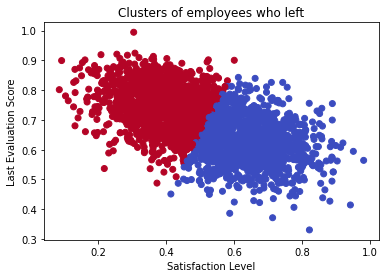

In [12]:
#import module
from sklearn.cluster import KMeans
# Filter data
left_emp =  df[['review', 'satisfaction']][df.left == 'yes']
# Create groups using K-means clustering.
kmeans = KMeans(n_clusters = 2, random_state = 0).fit(left_emp)

left_emp['label'] = kmeans.labels_
# Draw scatter plot
plt.scatter(left_emp['satisfaction'], left_emp['review'], c=left_emp['label'],cmap='coolwarm')
plt.xlabel('Satisfaction Level')
plt.ylabel('Last Evaluation Score')
plt.title('Clusters of employees who left')
plt.show()

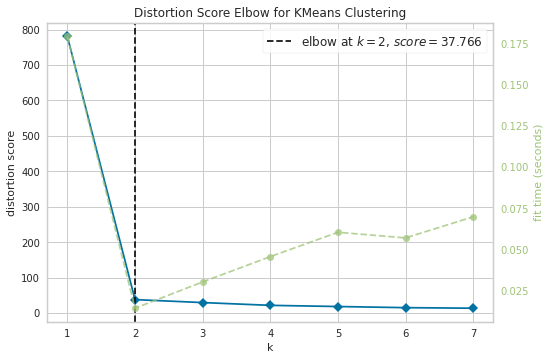

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [13]:
from yellowbrick.cluster import KElbowVisualizer

# Instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,8))

visualizer.fit(left_emp)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

<p> Very strange result, it seems that the better performers are less satisfied! </p>

<p> Let's try break this up to see if there are any departments that are skewing this, or if its a general companywide theme... </p>
 
Taking a look at it by department level to see if there are any obvious outliers:

In [14]:
fig = px.scatter(df, x="satisfaction", y="review", color="left", facet_col="department",   labels={'review':'Latest Review Results (Higher is better)', 'satisfaction': 'Reported Satisfaction'}, trendline='ols', trendline_color_override ='#fcba03', color_discrete_sequence=px.colors.qualitative.G10)
fig.show()

Nothing that stands out. Happy with this clustering from here on out we can start categorising our employees who have left the company by 2 common clusters or themes.

We'll label them as our:

 * <b>Frustrated Outperformers</b>: High Evaluation Scores but Low Satisfaction Scores (shaded by Red). 
 * <b>Satisifed Underperformers</b>: Low Evaluation Scores and High Satisfaction scores (Shaded by Blue). 
 
 
Starting with our <b>Frustrated Outperformers</b>, lets see if we can determine if they're working more than expected:

# 4. Deep Dive

Well start by introducing our classification back into our original data. This will be called "kmean_cat"

In [15]:
# Assign clustered categories back to original dataframe
df1 = df.loc[df.left == 'yes']
df1['kmean_cat'] = left_emp['label'] 

# Update Labels
label_encoding = {"kmean_cat":{0:"Underperformers",1: "Outperformers"} }
df1 = df1.replace(label_encoding)
df1.head()

,department,promoted,review,projects,salary,tenure,satisfaction,bonus,avg_hrs_month,left,kmean_cat
386,sales,0,0.700577,4,medium,5.0,0.484936,0,180.787350,yes,Outperformers
785,sales,0,0.738060,4,medium,5.0,0.534547,0,179.534464,yes,Outperformers
1078,sales,0,0.600301,3,low,6.0,0.657108,0,182.426505,yes,Underperformers
1155,operations,0,0.722790,3,medium,6.0,0.472769,0,181.921952,yes,Outperformers
1190,support,0,0.679845,3,medium,4.0,0.543203,0,177.469579,yes,Underperformers


In [16]:
# Convert salary from "low, medium, High" to "1, 2, 3" to build a correlation
df1 = df1.loc[df1['kmean_cat'] == "Outperformers"]
label_encoding = {"salary":{"low":1,"medium": 2, "high": 3} }
df2 = df1.replace(label_encoding)
df2.head()

,department,promoted,review,projects,salary,tenure,satisfaction,bonus,avg_hrs_month,left,kmean_cat
386,sales,0,0.700577,4,2,5.0,0.484936,0,180.787350,yes,Outperformers
785,sales,0,0.738060,4,2,5.0,0.534547,0,179.534464,yes,Outperformers
1155,operations,0,0.722790,3,2,6.0,0.472769,0,181.921952,yes,Outperformers
2689,sales,0,0.646720,2,2,6.0,0.467399,0,183.460142,yes,Outperformers
2952,sales,0,0.753666,4,1,5.0,0.539612,0,180.903977,yes,Outperformers


Looking at our Outperformers group (Frustrated outperformers), lets see if there are any standout correlations here..

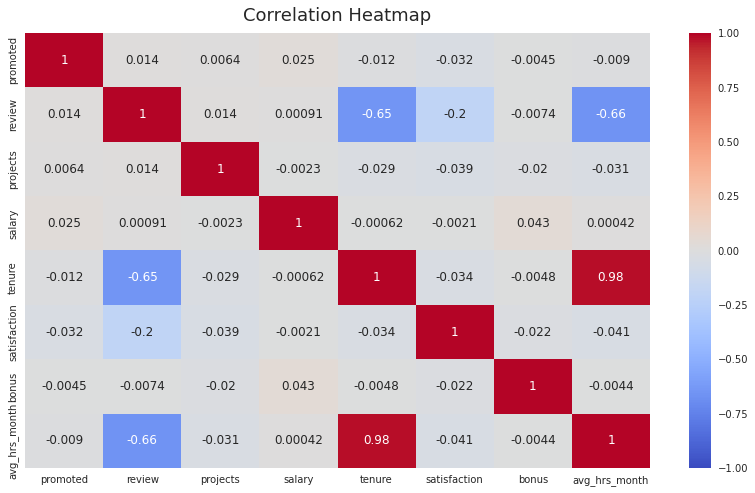

In [17]:
plt.figure(figsize=(14, 8))
heatmap = sns.heatmap(df2.corr(), vmin=-1, vmax=1, annot=True, cmap='coolwarm')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=12);# save heatmap as .png file
# dpi - sets the resolution of the saved image in dots/inches
# bbox_inches - when set to 'tight' - does not allow the labels to be croppedplt.savefig('heatmap.png', dpi=300, bbox_inches='tight')

While correlation doesnt equal causation, we could make a strong assumption here that the below are true (remember our group are all considered Unsatisfied and Outperforming):

* Tenure has a strong positive correlation with the average number of hours worked per month (we've already established that previously but we can see its just as strong here). <b>Indicating our outperformers are still working longer hours.</b>
* Tenure has a reasonably strong negative correlation with review scores (or performance scores). <b>Indicating the longer an employee works here, the lower their review scores are.</b>
* Average hours worked per month has a reasonably strong negative correlation with review scores (or performance scores). <b>Indicating a potential for overwork and burn out.</b>